In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Import librairies

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import tkinter as tk
from tkinter import filedialog
import pathlib
import glob
from zipfile import ZipFile
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR

#### Import Data

In [3]:
#https://drive.google.com/file/d/0B7jaG1vRBvyfcHRvaENYNzRfVGM/view?usp=share_link&resourcekey=0-2c1J83sMsujf-OCXW_OWTQ

!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7jaG1vRBvyfcHRvaENYNzRfVGM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7jaG1vRBvyfcHRvaENYNzRfVGM" -O logo.zip && rm -rf /tmp/cookies.txt

logo.zip            100%[===================>]   1.95G   213MB/s    in 9.8s    


In [4]:
#unzip the dataset
with ZipFile('logo.zip', 'r') as zipObj:
  zipObj.extractall('logo')

In [5]:
# Define image directory
data_dir = "/kaggle/working/logo/images"
data_dir = pathlib.Path(data_dir)

In [6]:
#set the hyper parameters
batch_size = 32
img_height = 600
img_width = 600

### Data Exploratory

In [7]:
#set a train set
train_image = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    color_mode='rgb',
    batch_size=32,
    image_size=(600,600)
    
)

Found 7830 files belonging to 32 classes.


In [8]:
#number of classes
class_names = train_image.class_names
print(class_names)

['HP', 'adidas', 'aldi', 'apple', 'becks', 'bmw', 'carlsberg', 'chimay', 'cocacola', 'corona', 'dhl', 'erdinger', 'esso', 'fedex', 'ferrari', 'ford', 'fosters', 'google', 'guinness', 'heineken', 'milka', 'nvidia', 'paulaner', 'pepsi', 'rittersport', 'shell', 'singha', 'starbucks', 'stellaartois', 'texaco', 'tsingtao', 'ups']


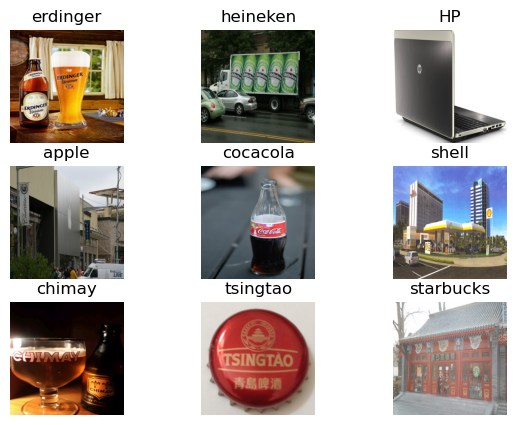

In [9]:
# Display sample images
plt.figure(figsize=(7,5))
for images, labels in train_image.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [10]:
# Compute dataset statistics
num_images = train_image.cardinality().numpy()*batch_size
num_classes = len(class_names) #nbre de classes
num_images_per_class = [0] * num_classes
mean_image_size = train_image.map(lambda img, label: tf.shape(img)[0]).reduce(tf.constant(0), lambda x, y: x + y) / num_images
#mean_image_size = train_image.map(lambda img: tf.shape(img)[0]).reduce(tf.constant(0), lambda x, y: x + y) / num_images

for images, labels in train_image:
    for label in labels:
        num_images_per_class[label] += 1

In [11]:
# Create a list of dictionaries for each class
class_stats = []
for i in range(num_classes):
    class_stat = {
        'Class': class_names[i],
        'Num_Images': num_images_per_class[i],#number of image per class
        'Num_Percent': num_images_per_class[i] / num_images * 100,#proportion of the class to the total number of images
    }
    class_stats.append(class_stat)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(class_stats)

# Add summary statistics to the DataFrame
df.loc[num_classes] = ['Summary', num_images, 100]
df['Mean_Size'] = mean_image_size.numpy()

# Set the DataFrame index to be the class names
df.set_index('Class', inplace=True)

# Print the DataFrame
print(df)

              Num_Images  Num_Percent  Mean_Size
Class                                           
HP                   266     3.392857   0.998724
adidas               166     2.117347   0.998724
aldi                 157     2.002551   0.998724
apple                433     5.522959   0.998724
becks                141     1.798469   0.998724
bmw                  502     6.403061   0.998724
carlsberg            287     3.660714   0.998724
chimay               267     3.405612   0.998724
cocacola             341     4.349490   0.998724
corona               392     5.000000   0.998724
dhl                  348     4.438776   0.998724
erdinger             249     3.176020   0.998724
esso                 169     2.155612   0.998724
fedex                225     2.869898   0.998724
ferrari              499     6.364796   0.998724
ford                 177     2.257653   0.998724
fosters              143     1.823980   0.998724
google               115     1.466837   0.998724
guinness            

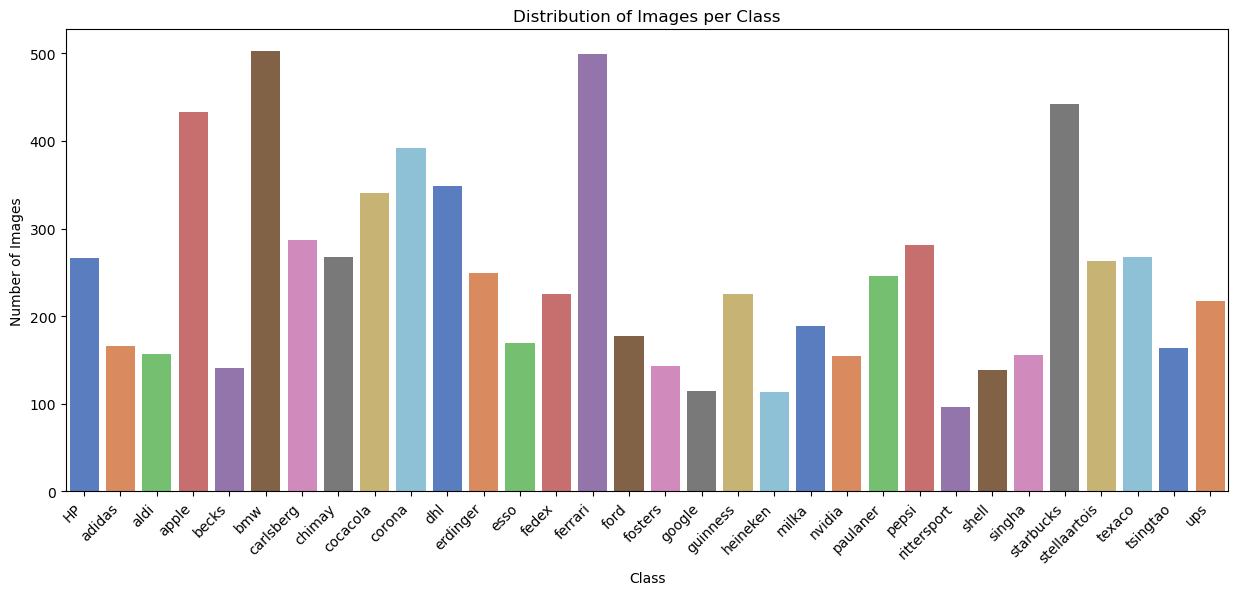

In [12]:
# Plot distribution of images per class
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.barplot(x=class_names, y=num_images_per_class, palette="muted")
plt.xticks(rotation=45, ha='right')

plt.title("Distribution of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

## Data Preparation

In [13]:
## split a train set and create a test folder

import os
import random
import shutil

test_dir = "/kaggle/working/logo/test"
data_dir = "/kaggle/working/logo/images"
test_ratio = 0.2  # 20% pour le test

# Créer le répertoire de validation s'il n'existe pas déjà
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

for dirpath, dirnames, filenames in os.walk(data_dir):
    # Parcourir tous les dossiers et sous-dossiers
    for dirname in dirnames:
        # Si le dossier est un dossier principal
        if not dirname.startswith('.'):
            train_subdir = os.path.join(dirpath, dirname)
            val_subdir = train_subdir.replace(data_dir, test_dir)

            # Créer le sous-répertoire de validation s'il n'existe pas déjà
            if not os.path.exists(val_subdir):
                os.makedirs(val_subdir)

            # Liste de tous les fichiers dans le sous-répertoire d'entraînement
            files = os.listdir(train_subdir)

            # Mélanger les fichiers de manière aléatoire
            random.shuffle(files)

            # Calculer le nombre de fichiers à déplacer pour la validation
            num_val = int(len(files) * test_ratio)

            # Déplacer les fichiers dans le sous-répertoire de validation
            for file in files[:num_val]:
                src_path = os.path.join(train_subdir, file)
                dst_path = os.path.join(val_subdir, file)
                shutil.move(src_path, dst_path)

In [ ]:
#split a train set and create a validation folder
val_dir = "/kaggle/working/logo/val"
data_dir = "/kaggle/working/logo/images"
val_ratio = 0.4  # 40% pour la validation

# Créer le répertoire de validation s'il n'existe pas déjà
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

for dirpath, dirnames, filenames in os.walk(data_dir):
    # Parcourir tous les dossiers et sous-dossiers
    for dirname in dirnames:
        # Si le dossier est un dossier principal
        if not dirname.startswith('.'):
            train_subdir = os.path.join(dirpath, dirname)
            val_subdir = train_subdir.replace(data_dir, val_dir)

            # Créer le sous-répertoire de validation s'il n'existe pas déjà
            if not os.path.exists(val_subdir):
                os.makedirs(val_subdir)

            # Liste de tous les fichiers dans le sous-répertoire d'entraînement
            files = os.listdir(train_subdir)

            # Mélanger les fichiers de manière aléatoire
            random.shuffle(files)

            # Calculer le nombre de fichiers à déplacer pour la validation
            num_val = int(len(files) * val_ratio)

            # Déplacer les fichiers dans le sous-répertoire de validation
            for file in files[:num_val]:
                src_path = os.path.join(train_subdir, file)
                dst_path = os.path.join(val_subdir, file)
                shutil.move(src_path, dst_path)

In [17]:
# create a train,test and validation set
val_dir = "/kaggle/working/logo/val"
val_dir = pathlib.Path(val_dir)
test_dir="/kaggle/working/logo/test"
test_dir = pathlib.Path(test_dir)
train_dir="/kaggle/working/logo/images"
train_dir = pathlib.Path(train_dir)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,validation_split = 0.3, subset = "training", seed = 42,image_size = (img_height,img_width), batch_size = batch_size)
#val_data = tf.keras.preprocessing.image_dataset_from_directory(
 #   val_dir,validation_split = 0.2, subset = "validation", seed = 123,image_size = (img_height,img_width), batch_size = batch_size)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,image_size = (img_height,img_width), batch_size = batch_size)

Found 6278 files belonging to 32 classes.
Using 4395 files for training.
Found 1552 files belonging to 32 classes.


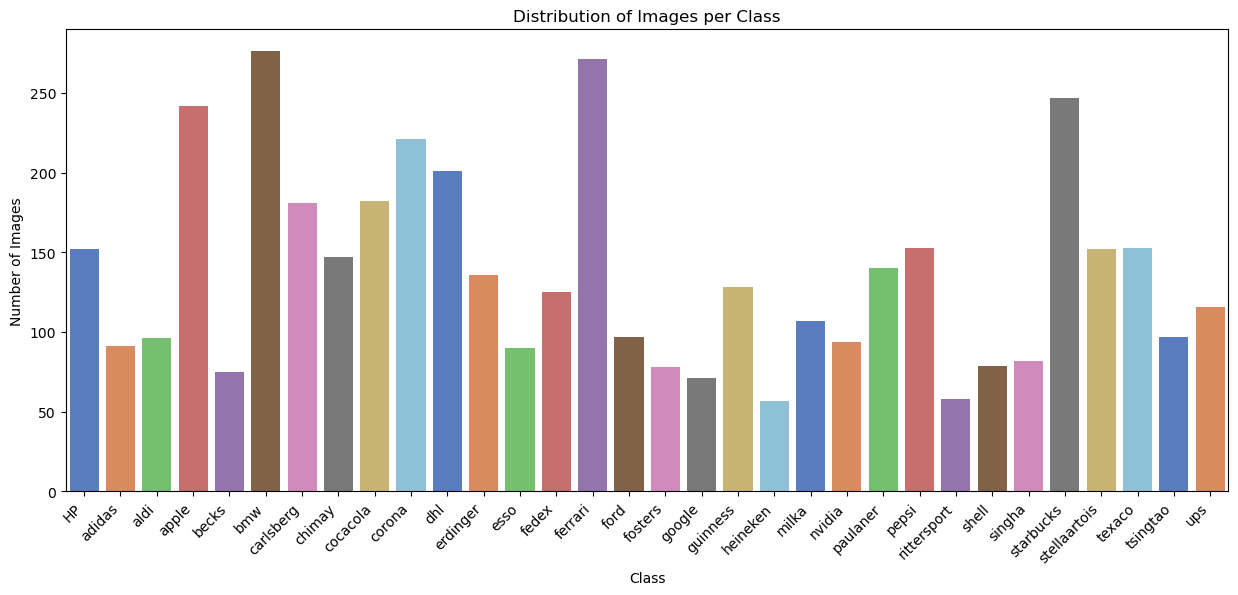

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 6))
class_name = train_data.class_names
num_image = train_data.cardinality().numpy()*batch_size
num_classe = len(class_name) #nbre de classes
num_image_per_class = [0] * num_classe
for images, labels in train_data:
    for label in labels:
        num_image_per_class[label] += 1

sns.barplot(x=class_name ,y=num_image_per_class, palette="muted")
plt.xticks(rotation=45, ha='right')

plt.title("Distribution of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

### Analysing the class imbalanced of the data

total training image count = 6278 

-------------------------------------
Class name =  HP
count      =  213
proportion =  0.03392800254858235
-------------------------------------
Class name =  adidas
count      =  133
proportion =  0.021185090793246257
-------------------------------------
Class name =  aldi
count      =  126
proportion =  0.020070086014654348
-------------------------------------
Class name =  apple
count      =  347
proportion =  0.05527237973877031
-------------------------------------
Class name =  becks
count      =  113
proportion =  0.017999362854412233
-------------------------------------
Class name =  bmw
count      =  402
proportion =  0.06403313157056387
-------------------------------------
Class name =  carlsberg
count      =  230
proportion =  0.03663587129659127
-------------------------------------
Class name =  chimay
count      =  214
proportion =  0.034087288945524055
-------------------------------------
Class name =  cocacola
count      =  273
p

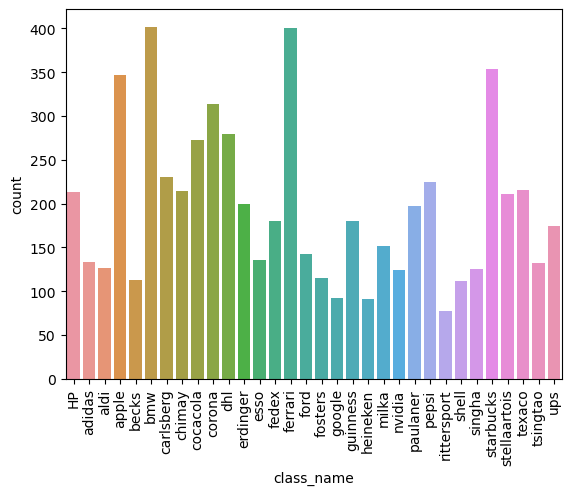

In [19]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Findings:
Data is hevily imbalance and hence due to that results and predictions will be baised.

### Data Augmentation:

### Augmentor : Class balance

In [20]:
!pip install Augmentor

In [26]:
! rm -rf /kaggle/working/data/

In [30]:
train_dir="/kaggle/working/logo/images/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(train_dir + i, output_directory='/kaggle/working/data/'+i+'/output/')
    #p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # Transformation : rotate avec une probabilité de 0.7 et un angle maximum de 10 degrés à gauche et à droite
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    # Transformation : flip_left_right avec une probabilité de 0.5
    p.flip_left_right(probability=0.5)
    
    # Transformation : flip_top_bottom avec une probabilité de 0.5
    p.flip_top_bottom(probability=0.5)
    
    # Transformation : crop_random avec une probabilité de 0.7 et une taille minimale de 0.5 et maximale de 0.9
    p.crop_random(probability=0.7, percentage_area=0.8)
    
    # Transformation : random_contrast avec une probabilité de 0.7 et un facteur minimum de 0.8 et maximum de 1.2
    p.random_contrast(probability=0.7, min_factor=0.8, max_factor=1.2)
    
    # Transformation : random_brightness avec une probabilité de 0.7 et un facteur minimum de 0.8 et maximum de 1.2
    p.random_brightness(probability=0.7, min_factor=0.8, max_factor=1.2)
    
    # Transformation : random_color avec une probabilité de 0.7 et un facteur minimum de 0.8 et maximum de 1.2
    p.random_color(probability=0.7, min_factor=0.8, max_factor=1.2)
    p.sample(400) 

Initialised with 213 image(s) found.
Output directory set to /kaggle/working/data/HP/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DFFEC698510>: 100%|██████████| 400/400 [00:20<00:00, 19.07 Samples/s] 


Initialised with 133 image(s) found.
Output directory set to /kaggle/working/data/adidas/output/.

Processing <PIL.Image.Image image mode=RGB size=508x819 at 0x7DFFEC671250>: 100%|██████████| 400/400 [00:21<00:00, 18.41 Samples/s]   


Initialised with 126 image(s) found.
Output directory set to /kaggle/working/data/aldi/output/.

Processing <PIL.Image.Image image mode=RGB size=460x726 at 0x7DFFEC7AB4D0>: 100%|██████████| 400/400 [00:20<00:00, 19.71 Samples/s]  


Initialised with 347 image(s) found.
Output directory set to /kaggle/working/data/apple/output/.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x7DFFEC6407D0>: 100%|██████████| 400/400 [00:20<00:00, 19.06 Samples/s]  


Initialised with 113 image(s) found.
Output directory set to /kaggle/working/data/becks/output/.

Processing <PIL.Image.Image image mode=RGB size=819x461 at 0x7DFFEC5E8D10>: 100%|██████████| 400/400 [00:20<00:00, 19.57 Samples/s]  


Initialised with 402 image(s) found.
Output directory set to /kaggle/working/data/bmw/output/.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x7DFFF453CA90>: 100%|██████████| 400/400 [00:21<00:00, 18.95 Samples/s]  


Initialised with 230 image(s) found.
Output directory set to /kaggle/working/data/carlsberg/output/.

Processing <PIL.Image.Image image mode=RGB size=768x1024 at 0x7DFFEC6A6E10>: 100%|██████████| 400/400 [00:20<00:00, 19.71 Samples/s] 


Initialised with 214 image(s) found.
Output directory set to /kaggle/working/data/chimay/output/.

Processing <PIL.Image.Image image mode=RGB size=688x1024 at 0x7DFFEC663550>: 100%|██████████| 400/400 [00:21<00:00, 18.77 Samples/s]                   


Initialised with 273 image(s) found.
Output directory set to /kaggle/working/data/cocacola/output/.

Processing <PIL.Image.Image image mode=RGB size=500x588 at 0x7DFFEC64F550>: 100%|██████████| 400/400 [00:21<00:00, 18.45 Samples/s]  


Initialised with 314 image(s) found.
Output directory set to /kaggle/working/data/corona/output/.

Processing <PIL.Image.Image image mode=RGB size=614x819 at 0x7DFFEC7AB710>: 100%|██████████| 400/400 [00:20<00:00, 19.55 Samples/s]   


Initialised with 279 image(s) found.
Output directory set to /kaggle/working/data/dhl/output/.

Processing <PIL.Image.Image image mode=RGB size=819x521 at 0x7DFFEC5DF1D0>: 100%|██████████| 400/400 [00:20<00:00, 19.71 Samples/s]   


Initialised with 200 image(s) found.
Output directory set to /kaggle/working/data/erdinger/output/.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x7DFFEC5D0C90>: 100%|██████████| 400/400 [00:21<00:00, 18.66 Samples/s]   


Initialised with 136 image(s) found.
Output directory set to /kaggle/working/data/esso/output/.

Processing <PIL.Image.Image image mode=L size=819x539 at 0x7DFFEC640E50>: 100%|██████████| 400/400 [00:19<00:00, 20.29 Samples/s]     


Initialised with 180 image(s) found.
Output directory set to /kaggle/working/data/fedex/output/.

Processing <PIL.Image.Image image mode=RGB size=819x557 at 0x7DFFEC624E90>: 100%|██████████| 400/400 [00:20<00:00, 19.11 Samples/s]  


Initialised with 400 image(s) found.
Output directory set to /kaggle/working/data/ferrari/output/.

Processing <PIL.Image.Image image mode=RGB size=819x548 at 0x7DFFEC5BCE10>: 100%|██████████| 400/400 [00:21<00:00, 18.84 Samples/s]  


Initialised with 142 image(s) found.
Output directory set to /kaggle/working/data/ford/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x680 at 0x7DFFEC651350>: 100%|██████████| 400/400 [00:21<00:00, 18.70 Samples/s] 


Initialised with 115 image(s) found.
Output directory set to /kaggle/working/data/fosters/output/.

Processing <PIL.Image.Image image mode=RGB size=246x819 at 0x7DFFEC5D3950>: 100%|██████████| 400/400 [00:18<00:00, 21.41 Samples/s]   


Initialised with 92 image(s) found.
Output directory set to /kaggle/working/data/google/output/.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x7DFFF453C450>: 100%|██████████| 400/400 [00:19<00:00, 20.04 Samples/s]  


Initialised with 180 image(s) found.
Output directory set to /kaggle/working/data/guinness/output/.

Processing <PIL.Image.Image image mode=RGB size=464x720 at 0x7DFFEC6D9D50>: 100%|██████████| 400/400 [00:20<00:00, 19.37 Samples/s]   


Initialised with 91 image(s) found.
Output directory set to /kaggle/working/data/heineken/output/.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x7DFFEC73AAD0>: 100%|██████████| 400/400 [00:22<00:00, 17.83 Samples/s]                    


Initialised with 152 image(s) found.
Output directory set to /kaggle/working/data/milka/output/.

Processing <PIL.Image.Image image mode=RGB size=681x1024 at 0x7DFFEC6A9850>: 100%|██████████| 400/400 [00:21<00:00, 18.67 Samples/s]  


Initialised with 124 image(s) found.
Output directory set to /kaggle/working/data/nvidia/output/.

Processing <PIL.Image.Image image mode=RGB size=819x461 at 0x7DFFEC6D66D0>: 100%|██████████| 400/400 [00:19<00:00, 20.26 Samples/s]  


Initialised with 197 image(s) found.
Output directory set to /kaggle/working/data/paulaner/output/.

Processing <PIL.Image.Image image mode=RGB size=544x819 at 0x7DFFEC5C9690>: 100%|██████████| 400/400 [00:21<00:00, 18.21 Samples/s]   


Initialised with 225 image(s) found.
Output directory set to /kaggle/working/data/pepsi/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7DFFF439FE10>: 100%|██████████| 400/400 [00:21<00:00, 18.35 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/rittersport/output/.

Processing <PIL.Image.Image image mode=RGB size=819x546 at 0x7DFFF439F090>: 100%|██████████| 400/400 [00:20<00:00, 19.19 Samples/s]   


Initialised with 112 image(s) found.
Output directory set to /kaggle/working/data/shell/output/.

Processing <PIL.Image.Image image mode=RGB size=819x614 at 0x7DFFEC69D890>: 100%|██████████| 400/400 [00:21<00:00, 19.00 Samples/s]  


Initialised with 125 image(s) found.
Output directory set to /kaggle/working/data/singha/output/.

Processing <PIL.Image.Image image mode=RGB size=819x579 at 0x7DFFEC6A91D0>: 100%|██████████| 400/400 [00:19<00:00, 20.00 Samples/s]   


Initialised with 354 image(s) found.
Output directory set to /kaggle/working/data/starbucks/output/.

Processing <PIL.Image.Image image mode=RGB size=768x1024 at 0x7DFFEC5CEBD0>: 100%|██████████| 400/400 [00:21<00:00, 18.68 Samples/s] 


Initialised with 211 image(s) found.
Output directory set to /kaggle/working/data/stellaartois/output/.

Processing <PIL.Image.Image image mode=RGB size=614x819 at 0x7DFFEC6D6C90>: 100%|██████████| 400/400 [00:20<00:00, 19.22 Samples/s]   


Initialised with 215 image(s) found.
Output directory set to /kaggle/working/data/texaco/output/.

Processing <PIL.Image.Image image mode=RGB size=640x755 at 0x7DFFEC68CD90>: 100%|██████████| 400/400 [00:22<00:00, 17.67 Samples/s]   


Initialised with 132 image(s) found.
Output directory set to /kaggle/working/data/tsingtao/output/.

Processing <PIL.Image.Image image mode=RGB size=768x768 at 0x7DFFEC67E6D0>: 100%|██████████| 400/400 [00:21<00:00, 18.48 Samples/s]   


Initialised with 174 image(s) found.
Output directory set to /kaggle/working/data/ups/output/.

Processing <PIL.Image.Image image mode=RGB size=819x528 at 0x7DFFEC6ABE50>: 100%|██████████| 400/400 [00:20<00:00, 19.93 Samples/s]   


In [31]:
output_dir = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

12800


total training image count = 12800 

-------------------------------------
Class name =  HP
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  adidas
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  aldi
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  apple
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  becks
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  bmw
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  carlsberg
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  chimay
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  cocacola
count      =  400
proportion =  0.03125
-------------------------------------
Class name =  corona
count      =  400
p

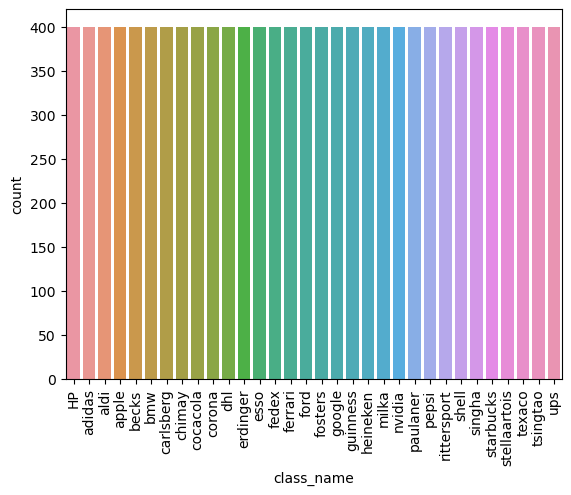

In [32]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

### PreProcessing

In [33]:
train_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.3),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
    tf.keras.layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406],
                                                             variance=[0.229, 0.224, 0.225])
])

val_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.CenterCrop(224, 224),
     tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
    tf.keras.layers.experimental.preprocessing.Normalization(
        mean=[0.485, 0.456, 0.406],
        variance=[0.229, 0.224, 0.225])
])

test_transform=  tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.CenterCrop(224, 224),
     tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
    tf.keras.layers.experimental.preprocessing.Normalization(
        mean=[0.485, 0.456, 0.406],
        variance=[0.229, 0.224, 0.225])
])

In [48]:
train = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(224,224),
  batch_size=batch_size)

val= tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(224,224),
  batch_size=batch_size)


Found 12800 files belonging to 32 classes.
Using 10240 files for training.
Found 12800 files belonging to 32 classes.
Using 2560 files for validation.


In [35]:
print(train_ds.class_names)

['HP', 'adidas', 'aldi', 'apple', 'becks', 'bmw', 'carlsberg', 'chimay', 'cocacola', 'corona', 'dhl', 'erdinger', 'esso', 'fedex', 'ferrari', 'ford', 'fosters', 'google', 'guinness', 'heineken', 'milka', 'nvidia', 'paulaner', 'pepsi', 'rittersport', 'shell', 'singha', 'starbucks', 'stellaartois', 'texaco', 'tsingtao', 'ups']


In [44]:
ds_train = train_ds.map(lambda x, y: (train_transform(x), y))
ds_val= val_ds.map(lambda x, y: (val_transform(x), y))
#test_ds= val_data.map(lambda x, y: (test_transform(x), y))

### Modeling

#### GoogleNet

In [50]:
#Googlenet model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(32, activation='softmax')(x)
gnet = Model(inputs=base_model.input, outputs=predictions)
gnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#gnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
gnet_history=gnet.fit(train, validation_data = val,epochs =50, batch_size=32)

Epoch 1/50
117/320 [=========>....................] - ETA: 5:59 - loss: 20.1823 - accuracy: 0.0505

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = gnet_history.history['accuracy']
train_loss = gnet_history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(gnet_history.history['accuracy'])
ax[0].plot(gnet_history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(gnet_history.history['loss'])
ax[1].plot(gnet_history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss, train_acc = gnet.evaluate(train_data)
test_loss, test_acc   = gnet.evaluate(val_data)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

In [ ]:
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD

INIT_LR = 1e-4

baseModel = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(224,224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(32, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer="sgd",
   metrics=["accuracy"])

In [ ]:
sgd_history=model.fit(train_ds, validation_data = val_ds,epochs =50,
                      class_weight=class_weights, batch_size=32)